In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [29]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [30]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [31]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [32]:
# Save references to each table - this code confirms that the base class keys are the table names and type
from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()



['measurement', 'station']

In [33]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [34]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [35]:
Measurement = Base.classes.measurement
Station = Base.classes.station 

In [36]:
# Create our session (link) from Python to the DB - we always start out with a collection that will be where we place our tables known as the MetaData object. This object is essentially a facade around a Python dictionary that stores a series of Table objects keyed to their string name. 
session = Session(engine)

# Exploratory Precipitation Analysis

In [37]:
# Find the most recent date in the data set. In 35 and 36 lists the column names and types. Measurement has a date column. Order descending then most recent is first in the list
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017,8,23)- dt.timedelta(days=365)



In [39]:
# Perform a query to retrieve the data and precipitation scores i.e. apply a filter
precip_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()


In [40]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_score_df = pd.DataFrame(precip_scores , columns = ['date', 'precipitation'])


In [41]:
#cross check 
precip_score_df.head(10)

,date,precipitation
0,2016-08-23,0.0
1,2016-08-24,2.0
2,2016-08-25,2.0
3,2016-08-26,0.0
4,2016-08-27,0.0
5,2016-08-28,0.3
6,2016-08-29,0.0
7,2016-08-30,0.0
8,2016-08-31,3.3
9,2016-09-01,0.0


In [43]:
# Sort the dataframe by date (note that there are NaN values)
precip_score_df.set_index(precip_score_df['date'], inplace = True)
precip_score_df.head()

,date,precipitation
date,,
2016-08-23,2016-08-23,0.0
2016-08-24,2016-08-24,2.0
2016-08-25,2016-08-25,2.0
2016-08-26,2016-08-26,0.0
2016-08-27,2016-08-27,0.0


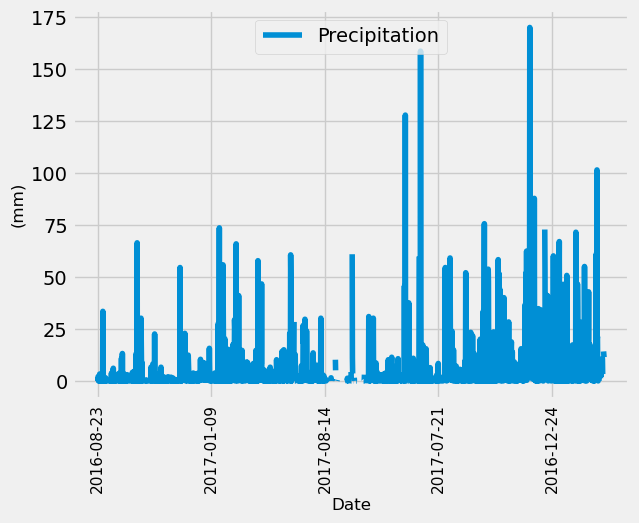

In [45]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_score_df.plot('date', 'precipitation')

fontsize = 12
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('(mm)', fontsize=fontsize)
plt.xticks(fontsize = (fontsize-1),  rotation=90)
plt.legend(["Precipitation"], loc="upper center")
plt.show()


In [46]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_score_df.describe()

,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [47]:
# Design a query to calculate the total number of stations in the dataset - this prints the station names
total_stations = session.query(Station.station).group_by(Station.station).all()
print(total_stations)


[('USC00511918',), ('USC00513117',), ('USC00514830',), ('USC00516128',), ('USC00517948',), ('USC00518838',), ('USC00519281',), ('USC00519397',), ('USC00519523',)]


In [48]:
#this counts the number of stations and provides the total 
total_stations = session.query(Station.station).group_by(Station.station).count()
print(total_stations)

9


In [49]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(Measurement.station,(func.count(Measurement.station))).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())
station_activity.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature. tobs = temperature observation
#Most active station id is top of the list from In(83)/Out[83] - 'USC00519281'
top_station_temp = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station =='USC00519281')
top_station_temp.first()   

('USC00519281', 21.1)

In [51]:
top_station_temp = pd.DataFrame(top_station_temp)
temps = top_station_temp['tobs']
print(f'Highest: {(temps).max()}, Lowest: {(temps.min())}, Average: {(temps).mean()}')

Highest: 29.4, Lowest: 12.2, Average: 22.035822510822513


In [54]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_temp_obs = session.query(Measurement.station, Measurement.tobs)\
    .filter(Measurement.date >= '2016-08-23')\
    .filter(Measurement.station == 'USC00519281')\
    .all()
max_temp_obs_df = pd.DataFrame(top_station_temp)
max_temp_obs_df.head()

,station,tobs
0,USC00519281,21.1
1,USC00519281,16.7
2,USC00519281,23.3
3,USC00519281,23.9
4,USC00519281,23.3


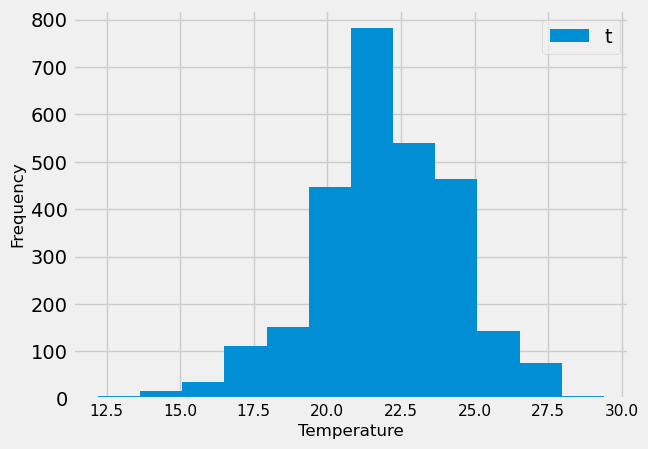

In [56]:
#results into a histogram - need to create number of bins as per Matplotlib documentation
histogram_data = max_temp_obs_df['tobs']
histogram_data.hist(bins = 12)

plt.xlabel('Temperature', fontsize=fontsize)
plt.ylabel('Frequency', fontsize=fontsize)
plt.legend('tobs',  loc="upper right")
plt.xticks(fontsize = (fontsize-1))
plt.show()

# Close Session

In [57]:
# Close Session
session.close()